### 연구 목적: Indoor moving patterns을 이용하여 revisit intention을 예측.

크롤링한 User들의 Wi-Fi log을, moving pattern별로 indexing한 후, 적합한 feature들을 선별하여, 어떤 moving pattern이 추후 customer revisit과 관련이 있는지 분석하고자 함.

#### Feature description:
특정 moving pattern의 revisit intention을 예측하는 supervised learning(classification) 모델에 이용될 feature들

**1. Feature 1 (History)**
    1. 해당 moving pattern이 일어난 시점까지 customer가 방문한 횟수: new_visit_count
**2. Feature 2-7 (Basic stats)**
    2. 해당 moving pattern에서 Wi-Fi에 연결된 area의 총 개수: num_logs
    3. 해당 moving pattern에서 Wi-Fi에 잡힌 총 시간(중복 포함 - 특정 시점에 다수의 Wi-Fi에 연결할 경우 시간을 모두 합함): total_dwell_time
    4. 해당 moving pattern에서 dwell_time > 100인 indoor area(stay point) 개수: num_sp_100
    5. 해당 moving pattern에서 customer가 방문한 indoor area의 총 개수 중에서 dwell_time > 100인 확률(방문한 area 중에서 stay point가 차지하는 비율): prob_dwell_100
    6. 해당 moving pattern에서 stay points에서 보낸 시간의 합(중복 포함 - 특정 시점에 다수의 Wi-Fi에 연결할 경우 시간을 모두 합함): time_sp_100
    7. 해당 moving pattern에서 dwell_time > 100인 indoor area들의 variance: std_sp_100
**3. Feature 8-14**
    8. 해당 moving pattern이 발생한 요일(Categorical variable): One-hot-encoding을 이용하여 Mon-Sun 7개의 feature(binary variable)로 표현
**4. Feature 15-137 (Trajectory)**
    9. Trajectory의 uni-gram, bi-gram features ('1f', '1f 1f', '1f 1f-inner', '1f 1f-left', '1f 1f-right', '1f 2f' ...) - 해당 moving pattern에 각 unigram 및 bigram이 몇 번 나왔는지 카운트


#### Details
1. Moving pattern: 한 유저가 하루 동안 매장 안에서 돌아다닌 와이파이 로그
2. Simple trajectory: Moving pattern에서 area를 시간 순서대로 나열한 sequence  (e.g., out,in,b1,b1-left-1,1f,out,in,b1-left)
2. Raw data의 경우 wi-fi에 찍힌 로그(어떤 device_id가 어떤 장소의 wi-fi 수신기에 몇시부터 몇초간 접속중이었고, 직원인지의 여부와, 현재까지의 revisit count와 가장 최근의 revisit interval)가 하나의 row로 이루어져 있다. 고로, 하나의 moving pattern에 대한 log가 여러 개로 이루어져 있는데, 로그의 날짜와 device_id를 조합하여 key로 삼고 aggregate하여 하나의 moving pattern이 하나의 row로 나타낼 수 있도록 함)
3. Raw data의 revisit_count 데이터를 보면 꼬인 경우가 많았다, 같은 device_id인데 오늘까지 revisit count가 69였는데 그다음날 7이 된다거나, 그래서 이 데이터를 이용하지 않고 새로 카운트해 주었다.
4. revisit_intention은 binary variable이며 우리가 예측하고자 하는 label이다, 매장 방문 이후 n일 (n=90) 이내에 다시 매장 방문 내역이 있다면 revisit_intention = 1 로 표시해 주었다.
5. 매장 방문의 정의: 특정 일에 특정 유저의 moving pattern이 out으로만 이루어진 로그가 아니면 매장을 방문하였다고 함. out만 여러번 있는 로그의 경우는 지나가는 행인이라고 생각하여 매장을 방문하지 않았다고 간주. (매장 방문 예시1: out,in,1f,1f-right  매장 방문 예시2: out,1f,1f-right,1f,out,2f,1f)
6. 따라서 어떤 유저의 timestamp가 가장 오래 된 방문을 가장 첫 방문이라고 가정하고, 그 다음 매장 방문이 발생하면 revisit_count를 1씩 더해 주었다, 이 때 각 방문 사이의 간격은 적어도 1일 이상이다. revisit_count는 각 방문 패턴의 history 정보를 누락시키지 않는다는 목적으로 feature로 삼기로 했다.
7. 참고: User-ID별로 indexing해서 유저별 revisit_count를 naive하게 예측한 이전 모델은 supervised_model(basic_features).ipynb 에 정리

#### 데이터
1. 786번 매장(코오롱 문정직영점) 데이터
    1. 직원이라고 한번이라도 로그에 찍힌 device_id는 제거
    2. 각 moving pattern별로 재인덱싱 이후 세어본 정식매장 방문 횟수(traj에 in을 포함한 경우) 22,642개(0: 19,953 vs 1: 2,689, revisit_intention 여부) 
    3. 위 데이터의 revisit intention label 비율을 50:50로 조절한 총 5,378개(0: 2,689 vs 1: 2,689)의 moving patterns을 최종으로 이용함.

####  Preliminary results
<pre>
* 10-fold CV 결과의 평균값
    * Area Under Curve
        * 3 Nearest Neighbors 0.7656
        * AdaBoost            0.8620
        * Naive Bayes         0.8536
        * Decision Tree       0.8636
        * Random Forest       0.8654
    * F1
        * Naive Bayes         0.5718
        * 3 Nearest Neighbors 0.7125
        * Decision Tree       0.7381
        * AdaBoost            0.7533
        * Random Forest       0.7661
        
* XGBOOST 결과
    *    train-auc:     0.8997	 eval-auc:     0.8602
         train-logloss: 0.3817	 eval-logloss: 0.4303
         train-error:   0.2099	 eval-error:   0.2340		
      
    *    test-auc:  0.900915750916
</pre>

In [1]:
### import libraries
import pandas as pd
import datetime
import numpy as np
import re

In [2]:
### 각 moving pattern별로 재인덱싱한 데이터 로드
trajs_combined = pd.read_pickle("../data/786/786_trajs_combined.p")

In [3]:
print(trajs_combined.shape)
trajs_combined.head(5)

(22642, 18)


,date,device_id,traj,new_visit_count,num_logs,total_dwell_time,num_sp_100,prob_dwell_100,time_sp_100,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,revisit_intention
16675_02614c7588f7f8eaa0d3b9047ac08410,16675.0,02614c7588f7f8eaa0d3b9047ac08410,"out,in,1f,1f-right,2f-left,2f,2f-right",1.0,7,1267,3.0,0.500000,354.0,10.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_028a1f4dbca00ed06814fdda60f1b599,16675.0,028a1f4dbca00ed06814fdda60f1b599,"out,in,3f,2f,2f-right,2f-inner,2f-left,1f,1f-r...",1.0,11,7139,7.0,0.700000,3553.0,362.141251,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_062c73a8b307fd05f6af2472a35671ef,16675.0,062c73a8b307fd05f6af2472a35671ef,"out,in,1f,1f-inner",1.0,4,2189,2.0,0.666667,1130.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_06c041f68ec481883941d47d99d6903f,16675.0,06c041f68ec481883941d47d99d6903f,"out,in,3f,in,1f,out",1.0,6,4259,4.0,1.000000,1286.0,159.307878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_0a47ed78e921824cf54dddcf49ae2911,16675.0,0a47ed78e921824cf54dddcf49ae2911,"out,in",1.0,2,2636,1.0,1.000000,457.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Revisit intention이 있는 경우와 없는 경우 모두 비슷한 trajectories를 가지고 있어서, history를 고려하지 않는다고 할 때, indoor moving pattern만으로 classification이 가능할 지 걱정이 된다 (아래 참고)

In [4]:
### 어떤 trajectories가 있나 확인 (revisit_intention == 1인 경우)
print('Top 10 trajectories with revisit intention in 3 months\n', trajs_combined.loc[trajs_combined['revisit_intention'] == 1]['traj'].value_counts().head(10))
print(' ')
### 어떤 trajectories가 있나 확인 (revisit_intention == 0인 경우)
print('Top 10 trajectories with no revisit intention in 3 months\n', trajs_combined.loc[trajs_combined['revisit_intention'] == 0]['traj'].value_counts().head(10))

Top 10 trajectories with revisit intention in 3 months
 out,in,1f             335
out,in                228
out,in,2f              92
out,in,1f,1f-right     78
out,in,1f,out          69
out,out,in,1f          59
out,in,1f-right,1f     47
out,out,in             40
out,in,out             38
out,in,1f,1f-inner     32
Name: traj, dtype: int64
 
Top 10 trajectories with no revisit intention in 3 months
 out,in,1f             3078
out,in                2196
out,in,2f              794
out,in,1f,out          663
out,in,1f,1f-right     624
out,out,in,1f          565
out,in,out             446
out,out,in             435
out,in,1f-right,1f     296
out,in,1f,1f-inner     290
Name: traj, dtype: int64


1.0    16036
2.0     1932
3.0      914
Name: new_visit_count, dtype: int64


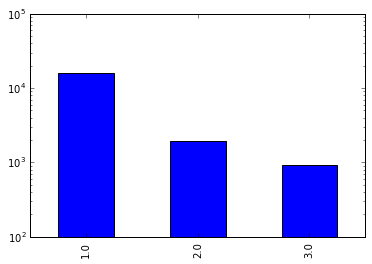

In [5]:
# 재방문 횟수별 사람 수
customer_revisit_count = trajs_combined.groupby(['device_id'])['new_visit_count'].max().value_counts().sort_index()
print (customer_revisit_count)

%matplotlib inline 
customer_revisit_count.plot(kind='bar', logy=True)

우리가 알고 싶은 방문객의 방문 횟수 범위는 3번 이하였다. 원본 데이터의 방문 횟수는 아래와 같다
![](2016-09-18_10.07.01.png)

### Final data preprocessing
라벨 비율 맞추기

In [6]:
## Revisit intention 비율을 50대 50으로 맞춤 (sampling)
# trajs_combined = trajs_combined.loc[trajs_combined['prob_deny']==0]
trajs_1 = trajs_combined.loc[trajs_combined['revisit_intention']==1]
trajs_0 = trajs_combined.loc[trajs_combined['revisit_intention']==0]

new_trajs_0 = trajs_0.iloc[np.random.permutation(len(trajs_0))][:trajs_1.shape[0]]  ## trajs_1의 크기에 맞게 trajs_0을 랜덤 샘플링.

# 1:1 비율의 dataframe 만들기
trajs_combined_balanced = pd.concat([trajs_1, new_trajs_0])
trajs_combined_balanced = trajs_combined_balanced.sample(frac=1)  ## reshuffle after concatenation

print(trajs_1.shape)
print(trajs_0.shape)
print(trajs_combined_balanced.shape) ## 이용할 데이터

(2689, 18)
(19953, 18)
(5378, 18)


In [13]:
df_learning = trajs_combined_balanced
df_learning = df_learning.fillna(0)
df_learning = df_learning.reindex(np.random.permutation(df_learning.index))
df_learning.tail(5)

,date,device_id,traj,new_visit_count,num_logs,total_dwell_time,num_sp_100,prob_dwell_100,time_sp_100,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,revisit_intention
16726_7a19471f288bdc5195cc2fc2e4a922bb,16726.0,7a19471f288bdc5195cc2fc2e4a922bb,"out,in,1f-left,1f,out,in,2f",1.0,7,1958,5.0,1.000000,862.0,62.624276,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16878_43292c0e3ec0b0de1c4ff00b0189d01d,16878.0,43292c0e3ec0b0de1c4ff00b0189d01d,"out,in,3f,2f,1f-right,1f",2.0,6,1646,1.0,0.200000,663.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16691_abfbc44a35880d9d2dade96d561a82cc,16691.0,abfbc44a35880d9d2dade96d561a82cc,"out,in,1f-left,1f",1.0,4,144,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16775_ae0c90bc80f6e6383f6f3af03ec1e16d,16775.0,ae0c90bc80f6e6383f6f3af03ec1e16d,"out,in",1.0,2,10092,1.0,1.000000,537.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16691_89811c043ce8f0e29215d8e2408a18c3,16691.0,89811c043ce8f0e29215d8e2408a18c3,"out,out,out,out,in,1f,1f-left,1f-inner,1f-righ...",1.0,13,2828,4.0,0.444444,1192.0,141.121697,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [15]:
data = np.asarray(df_learning)
X_small, y = data[:, 3:-1], data[:, -1].astype(int)

### Add some trajectory features (Uni-gram, Bi-gram)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
bigram_vectorizer = CountVectorizer(min_df=1, token_pattern='\w+\-*\w+', ngram_range=(1, 2))

### Test with toy example
analyze = bigram_vectorizer.build_analyzer()
print(analyze('Bi-grams are cool!') == (['bi-grams', 'are', 'cool', 'bi-grams are', 'are cool']))

### Trajecory를 이용하여 bi-gram 생성 후 각 moving pattern별로 count
corpus = trajs_combined_balanced['traj']
corpvec2 = bigram_vectorizer.fit_transform(corpus)
print(corpvec2.toarray())
corpvec2

X = np.concatenate((X_small, corpvec2.toarray()), axis=1)
newcolumns = df_learning.columns.tolist()[:-1]+bigram_vectorizer.get_feature_names()
print(newcolumns)
print(X.shape)

True
[[1 0 0 ..., 2 1 1]
 [1 0 0 ..., 2 1 1]
 [1 0 0 ..., 1 1 0]
 ..., 
 [0 0 0 ..., 1 1 0]
 [1 0 0 ..., 2 1 0]
 [1 0 0 ..., 1 1 0]]
['date', 'device_id', 'traj', 'new_visit_count', 'num_logs', 'total_dwell_time', 'num_sp_100', 'prob_dwell_100', 'time_sp_100', 'std_sp_100', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '1f', '1f 1f', '1f 1f-inner', '1f 1f-left', '1f 1f-right', '1f 2f', '1f 2f-inner', '1f 2f-left', '1f 2f-right', '1f 3f', '1f in', '1f out', '1f-inner', '1f-inner 1f', '1f-inner 1f-inner', '1f-inner 1f-left', '1f-inner 1f-right', '1f-inner 2f', '1f-inner 2f-inner', '1f-inner 2f-left', '1f-inner 2f-right', '1f-inner 3f', '1f-inner in', '1f-inner out', '1f-left', '1f-left 1f', '1f-left 1f-inner', '1f-left 1f-left', '1f-left 1f-right', '1f-left 2f', '1f-left 2f-inner', '1f-left 2f-left', '1f-left 2f-right', '1f-left 3f', '1f-left in', '1f-left out', '1f-right', '1f-right 1f', '1f-right 1f-inner', '1f-right 1f-left', '1f-right 1f-right', '1f-right 2f', '1f-right 2f-inner',

## Analysis with sklearn (easier classifier)

### Decision tree
* Decision tree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* Cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html

In [9]:
### DataFame to nparray, divide features and labels
data = np.asarray(df_learning)
X, y = data[:, 3:-1], data[:, -1].astype(int)
print("Features", X[1:5])
print("Labels", y[1:5])

Features [[1.0 5 3030 4.0 1.0 2144.0 87.39946605481447 1.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [1.0 3 218 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [2.0 4 161 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0]
 [1.0 6 5215 4.0 0.8 3318.0 642.8605343825881 0.0 0.0 0.0 0.0 1.0 0.0 0.0]]
Labels [0 1 1 1]


In [10]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
cross_val_score(clf, X, y, cv=10)   ## accuracy

array([ 0.61152416,  0.58921933,  0.57434944,  0.65613383,  0.59665428,
        0.60223048,  0.62081784,  0.60037175,  0.66542751,  0.60820896])